# C3O Paper: Performance Models and Impact of Training Data Availability

In [1]:
import sys
sys.path.insert(0, '..')
import collections

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from IPython.display import display, HTML
from ipywidgets import IntProgress

from RuntimePrediction.Predict import Predictor as C3OPredictor
from RuntimePrediction.DefaultModels import (GradientBoosting as GB,
                                             ErnestModel as EM)
from RuntimePrediction.CustomModels import (BasicOptimisticModel as BOM,
                                            OptimisticGradientBoosting as OGB)

## Define Models

In [2]:
Model = collections.namedtuple('Model', ['name', 'predictor', 'kwargs'])

models = [
          Model('Ernest', EM, {}),
          Model('GBM', GB, {}), 
          
          Model('BOM', BOM, {}), 
          Model('OGB', OGB, {}), 
   
          Model('C3O', C3OPredictor, {}),
         ]

## Extract Runtime Data

In [3]:
sort_df = pd.read_csv('../data/sort.tsv', sep='\t')
grep_df = pd.read_csv('../data/grep.tsv', sep='\t')
sgd_df = pd.read_csv('../data/sgd.tsv', sep='\t')
kmeans_df = pd.read_csv('../data/kmeans.tsv', sep='\t')
pagerank_df = pd.read_csv('../data/pagerank.tsv', sep='\t')

In [4]:
Job = collections.namedtuple('Job', ['name', 'X', 'y'])

def get_training_data(df, features, filters):
    # Get medians
    g = df.groupby(by=['instance_count','machine_type']+features)
    df = pd.DataFrame(g.median().to_records())
    # Apply filters 
    # e.g. only for one machine type each, the full c3o-experiments were conducted
    # No full cartesian product!
    for k, s, v in filters:
        if s == '==': df = df[df[k] == v] 
        if s == '>' : df = df[df[k] >  v]
    X = df[['instance_count'] + features]
    y = (df[['gross_runtime']]).squeeze()
    return X, y

td = get_training_data
jobs = [
    Job('Sort',
        *(td(sort_df,
            ['data_size_MB'],
            [('machine_type', '==', 'c4.2xlarge'),
             ('line_length', '==', 100)] )) ),
    Job('Grep',
        *(td(grep_df,
            ['data_size_MB', 'p_occurrence'],
            [('machine_type', '==', 'm4.2xlarge')] )) ),
    Job('SGDLR',
        *(td(sgd_df,
            ['observations', 'features', 'iterations'],
            [('machine_type', '==', 'r4.2xlarge'),
             ('instance_count', '>', 2)] )) ),
    Job('K-Means',
        *(td(kmeans_df,
            ['observations', 'features', 'k'],
            [('machine_type', '==', 'r4.2xlarge'),
             ('instance_count', '>', 2)] )) ),
    Job('Page Rank',
        *(td(pagerank_df,
            ['links', 'pages', 'convergence_criterion'],
            [('machine_type', '==', 'r4.2xlarge')] )) ),
]

## Train-Test Split Creations

In [5]:
common_features = {'Grep': ['p_occurrence'],
                   'SGDLR': ['iterations'],
                   'K-Means': ['k'],
                   'Page Rank': ['pages', 'convergence_criterion']}

def get_groups(X, y, common_features):
    # Get groups of observations that share the same value for certain features
    Xy = X.merge(y, right_index=True, left_index=True)
    grouped = Xy.groupby(by=common_features, as_index=True)
    X_keys, y_keys = [k for k in Xy.keys() if k != 'gross_runtime'], ['gross_runtime']
    Xs = [group[X_keys] for name, group in grouped]
    ys = [group[y_keys].squeeze() for name, group in grouped]
    return Xs, ys

In [6]:
def create_partial_training_data(job, splits, availability=30):
    # Availability of global training data: e.g. 40 or 1.0 (all)
    for _ in range(splits):
        yield train_test_split(job.X,job.y,train_size=availability) 

## Evaluate Models on the Training Datasets

In [7]:
# Display tables side by side and get rid of horizontal scroll bar under tables
HTML('''<style> \
     .output {flex-direction: row; flex-wrap: wrap} \
     div.output_subarea {padding-left: 0mm; padding-right:3mm} \
     </style>''')

In [8]:
def display_evaluation_counts(job_name):
    
    try: results = pd.read_csv('availability_results.csv', header=None)
    except: display(HTML(f"<h3>{job_name}</h3> None")); return
    
    rres = [(job, model, ds, round(float(mape),4)) for job, model, ds, mape in results.values]
    df = pd.DataFrame(rres, columns = ('Job', 'Model', 'Dataset', 'MAPE'))
    groups = df.groupby(by=['Job', 'Model', 'Dataset'], as_index=False)
    amounts = [(*group_key, len(instances)) for group_key, instances in groups]
    df = pd.DataFrame(amounts, columns=('Job', 'Model', 'Dataset', 'Amount'))
    
    # Filter info for just the job we are interested in
    jobdf = df[df['Job'] == job_name].set_index(['Model', 'Dataset'])[['Amount']].unstack()
    # Remove redundant info
    columns = (list(map(lambda x: x[1], jobdf.columns)))  # Puts global and local in order
    displaydf = pd.DataFrame(jobdf.values, index=jobdf.index, columns=columns)    
    
    # axis=None for whole table
    try: table_html = displaydf.style._repr_html_()
    except: table_html = "None"
    
    display(HTML(f"<h3>{job_name}</h3>" + table_html ))

### Amount of Conducted Evaluation Experiments Thus Far

In [9]:
for job in jobs:
    display_evaluation_counts(job.name)

,3,6,9,12,15,18,21,24,27,30
Model,,,,,,,,,,
BOM,308,300,300,300,300,300,300,300,300,300
C3O,307,300,300,300,300,300,300,300,300,300
Ernest,308,300,300,300,300,300,300,300,300,300
GBM,308,300,300,300,300,300,300,300,300,300
OGB,308,300,300,300,300,300,300,300,300,300


,3,6,9,12,15,18,21,24,27,30
Model,,,,,,,,,,
BOM,300,300,300,300,300,300,300,300,300,300
C3O,300,300,300,300,300,300,300,300,300,300
Ernest,300,300,300,300,300,300,300,300,300,300
GBM,300,300,300,300,300,300,300,300,300,300
OGB,300,300,300,300,300,300,300,300,300,300


,3,6,9,12,15,18,21,24,27,30
Model,,,,,,,,,,
BOM,300,300,300,300,300,300,300,300,300,300
C3O,300,300,300,300,300,300,300,300,300,300
Ernest,300,300,300,300,300,300,300,300,300,300
GBM,300,300,300,300,300,300,300,300,300,300
OGB,300,300,300,300,300,300,300,300,300,300


,3,6,9,12,15,18,21,24,27,30
Model,,,,,,,,,,
BOM,300,300,300,300,300,300,300,300,300,300
C3O,300,300,300,300,300,300,300,300,300,300
Ernest,300,300,300,300,300,300,300,300,300,300
GBM,300,300,300,300,300,300,300,300,300,300
OGB,300,300,300,300,300,300,300,300,300,300


,3,6,9,12,15,18,21,24,27,30
Model,,,,,,,,,,
BOM,300,300,300,300,300,300,300,300,300,300
C3O,300,300,300,300,300,300,300,300,300,300
Ernest,300,300,300,300,300,300,300,300,300,300
GBM,300,300,300,300,300,300,300,300,300,300
OGB,300,300,300,300,300,300,300,300,300,300


### Calculating the Model Prediction Errors

In [10]:
def evaluate(model, X_train, X_test, y_train, y_test, error_metric):
    model_instance = model.predictor(**model.kwargs)
    model_instance.fit(X_train, y_train)
    y_pred = model_instance.predict(X_test)
    error = error_metric(y_test, y_pred)
    return error

In [11]:
def create_new_availability_evaluations(amount):
    availabilities = np.arange(3,33,3)
    progress_bar = IntProgress(min=0, max=len(availabilities)*len(jobs)*amount); display(progress_bar)
    with open('availability_results.csv', 'at') as f:
        for availability in availabilities:
            for job in jobs:
                for split in create_partial_training_data(job, splits=amount, availability=availability):
                    for model in models:
                        error = evaluate(model, *split, MAPE)
                        f.write(f"{job.name},{model.name},{availability},{error}\n")
                    progress_bar.value += 1


### Conduct Additional Model Evaluation Experiments

In [12]:
create_new_availability_evaluations(amount=0)

IntProgress(value=0, max=0)

### Display the Results

In [13]:
def read_results(job_name):
    try: results = pd.read_csv('availability_results.csv', header=None)
    except: return

    rres = [(job, model, ds, float(mape)) for job, model, ds, mape in results.values]
    df = pd.DataFrame(rres, columns = ('Job', 'Model', 'Training Data', 'MAPE'))
    groups = df.groupby(by=['Job', 'Model', 'Training Data'], as_index=False)
    df = groups.mean()
    # Filter info for just the job we are interested in
    jobdf = df[df['Job'] == job_name].set_index(['Model', 'Training Data'])
    # Remove redundant info
    return jobdf.unstack()['MAPE']

def display_job_evaluation(job_name):
    
    try: displaydf = read_results(job_name)
    except: display(HTML(f"<h3>{job_name}</h3> None")); return 
    
    # Style the output to highlight the important information
    def highlight_row_min(row):
        return ['color: black' if cell == min(row) else 'color: dimgray' for cell in row]
    
    def highlight_min(data, color='aquamarine', bold=False):
        # highlight the minimum in a Series or DataFrame
        attr1 = f"background-color: {color}"
        attr2 = f"font-weight: {'bold' if bold else 'normal'}"
        if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
            is_min = data == data.min()
            return [attr1 if v else '' for v in is_min]
        else:  # from .apply(axis=None)
            is_min = data == data.min().min()
            return pd.DataFrame(np.where(is_min, attr2, ''),
                                index=data.index, columns=data.columns)
        
    table_html = displaydf.style.apply(highlight_row_min,axis=1) \
                                .apply(highlight_min, axis=0, color='aquamarine') \
                                .apply(highlight_min, axis=None, bold=True) \
                                .format("{:.2%}") \
                                ._repr_html_()
    
    display(HTML(f"<h3>{job_name}</h3>" + table_html ))

### Performance of the C3O Predictor and its Constituent Models

In [14]:
for job in jobs:
    display_job_evaluation(job.name)

Training Data,3,6,9,12,15,18,21,24,27,30
Model,,,,,,,,,,
BOM,47.56%,30.20%,33.99%,35.45%,20.31%,8.51%,7.49%,7.01%,6.45%,6.33%
C3O,13.83%,8.29%,7.39%,6.56%,6.16%,6.15%,5.52%,5.09%,4.21%,3.06%
Ernest,10.49%,6.99%,6.45%,6.09%,6.04%,5.94%,5.83%,5.75%,5.79%,5.70%
GBM,35.78%,25.64%,20.20%,15.09%,11.92%,9.73%,7.92%,6.67%,5.75%,4.90%
OGB,41.41%,34.89%,27.84%,23.07%,18.50%,14.06%,12.00%,9.41%,5.26%,2.93%


Training Data,3,6,9,12,15,18,21,24,27,30
Model,,,,,,,,,,
BOM,72.60%,35.84%,46.27%,26.36%,28.79%,31.81%,30.15%,33.78%,27.10%,26.54%
C3O,53.00%,37.04%,30.54%,25.86%,22.32%,19.00%,16.71%,14.98%,13.50%,12.36%
Ernest,57.88%,48.05%,43.78%,42.69%,42.47%,41.97%,41.20%,41.73%,41.99%,41.52%
GBM,48.78%,40.95%,32.76%,25.79%,21.57%,18.32%,15.85%,14.58%,12.96%,11.71%
OGB,49.89%,42.69%,36.46%,33.97%,31.71%,28.55%,26.54%,25.30%,24.82%,23.23%


Training Data,3,6,9,12,15,18,21,24,27,30
Model,,,,,,,,,,
BOM,83.60%,46.80%,31.50%,23.88%,22.77%,20.39%,18.67%,17.14%,16.66%,15.91%
C3O,37.56%,30.12%,26.33%,23.62%,22.62%,20.36%,18.48%,16.35%,15.23%,13.57%
Ernest,33.30%,26.22%,24.87%,23.93%,23.50%,23.32%,23.06%,22.81%,22.67%,22.66%
GBM,41.27%,34.59%,30.58%,25.99%,22.42%,20.03%,17.34%,15.90%,14.60%,13.29%
OGB,44.40%,39.62%,35.39%,29.49%,29.15%,26.44%,24.57%,21.94%,20.51%,18.42%


Training Data,3,6,9,12,15,18,21,24,27,30
Model,,,,,,,,,,
BOM,69.66%,46.17%,29.49%,25.24%,20.56%,18.47%,17.37%,15.34%,14.21%,12.30%
C3O,29.07%,22.47%,18.47%,17.38%,15.97%,14.66%,13.52%,12.06%,10.92%,9.88%
Ernest,23.85%,18.73%,17.28%,16.75%,16.42%,15.98%,16.00%,15.70%,15.65%,15.63%
GBM,35.54%,26.89%,22.06%,18.70%,16.44%,14.70%,13.17%,12.11%,11.01%,10.35%
OGB,45.08%,41.93%,36.53%,34.16%,30.48%,28.69%,27.53%,24.88%,22.41%,21.48%


Training Data,3,6,9,12,15,18,21,24,27,30
Model,,,,,,,,,,
BOM,1341.66%,36.23%,24.84%,20.62%,19.03%,18.16%,18.58%,17.72%,17.64%,17.54%
C3O,478.98%,38.07%,26.66%,21.92%,19.34%,18.35%,16.36%,14.62%,13.16%,11.59%
Ernest,53.57%,41.25%,40.00%,38.59%,36.71%,36.51%,36.43%,36.13%,35.69%,35.86%
GBM,39.58%,36.98%,30.86%,26.40%,22.38%,19.53%,17.26%,15.14%,13.41%,12.21%
OGB,38.27%,33.85%,27.87%,22.92%,18.88%,16.90%,15.12%,13.58%,12.18%,11.31%


### Updated Amount of Conducted Experiments per Evaluation Experiments Category

In [15]:
for job in jobs:
    display_evaluation_counts(job.name)

,3,6,9,12,15,18,21,24,27,30
Model,,,,,,,,,,
BOM,308,300,300,300,300,300,300,300,300,300
C3O,307,300,300,300,300,300,300,300,300,300
Ernest,308,300,300,300,300,300,300,300,300,300
GBM,308,300,300,300,300,300,300,300,300,300
OGB,308,300,300,300,300,300,300,300,300,300


,3,6,9,12,15,18,21,24,27,30
Model,,,,,,,,,,
BOM,300,300,300,300,300,300,300,300,300,300
C3O,300,300,300,300,300,300,300,300,300,300
Ernest,300,300,300,300,300,300,300,300,300,300
GBM,300,300,300,300,300,300,300,300,300,300
OGB,300,300,300,300,300,300,300,300,300,300


,3,6,9,12,15,18,21,24,27,30
Model,,,,,,,,,,
BOM,300,300,300,300,300,300,300,300,300,300
C3O,300,300,300,300,300,300,300,300,300,300
Ernest,300,300,300,300,300,300,300,300,300,300
GBM,300,300,300,300,300,300,300,300,300,300
OGB,300,300,300,300,300,300,300,300,300,300


,3,6,9,12,15,18,21,24,27,30
Model,,,,,,,,,,
BOM,300,300,300,300,300,300,300,300,300,300
C3O,300,300,300,300,300,300,300,300,300,300
Ernest,300,300,300,300,300,300,300,300,300,300
GBM,300,300,300,300,300,300,300,300,300,300
OGB,300,300,300,300,300,300,300,300,300,300


,3,6,9,12,15,18,21,24,27,30
Model,,,,,,,,,,
BOM,300,300,300,300,300,300,300,300,300,300
C3O,300,300,300,300,300,300,300,300,300,300
Ernest,300,300,300,300,300,300,300,300,300,300
GBM,300,300,300,300,300,300,300,300,300,300
OGB,300,300,300,300,300,300,300,300,300,300


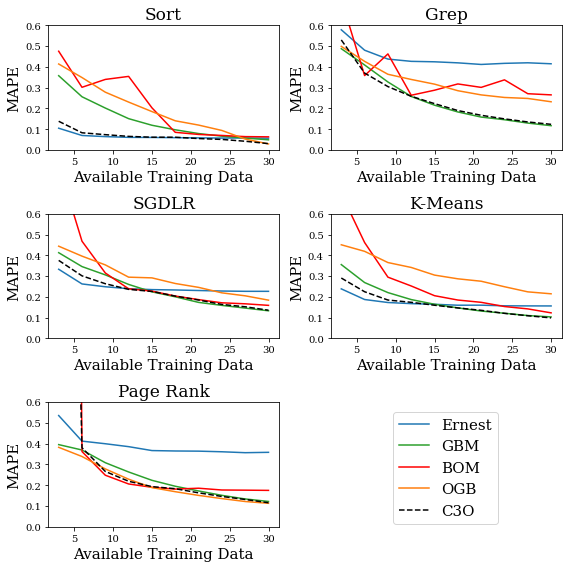

In [16]:
#ff = 'DejaVu Sans'
ff = 'DejaVu Serif'
matplotlib.rc('font', family=ff)

model_names = list(map(lambda m:m.name, models))

colors = ['tab:blue', 'tab:green', 'red', 'tab:orange', 'black']

plt.figure(figsize=(8,8))
for i, job in enumerate(jobs):
    results = read_results(job.name)
    plt.subplot(3,2,i+1)
    plt.title(job.name, fontsize=17)
    for j, model_name in enumerate(model_names):
        y = results.loc[model_name][:]
        x =  results.loc[model_name].keys()
        line = plt.plot(x, y, '--' if model_name=='C3O' else '-', label=model_name, color=colors[j])
            
        plt.xlabel('Available Training Data', fontsize=15)
        plt.ylabel('MAPE', fontsize=15)
        
        plt.ylim(0, .6)

plt.figlegend(model_names, fontsize=15, loc='lower center', ncol=1, bbox_to_anchor=[0.78, +.07], 
              bbox_transform=plt.gcf().transFigure)
plt.tight_layout()
plt.savefig('availability.pdf', bbox_inches='tight')
plt.show()